In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns   
from scipy.signal import butter, filtfilt
# import seglearn as sglearn        # For windowing and sequence modeling
import tsfresh     
import os
 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Exploration

In [2]:
# File paths for three training datasets
defog = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog'
notype = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/notype'
tdcsfog = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog'

Load dataset

In [3]:
df_defog = pd.DataFrame()

for file in os.listdir(defog):
    df_defog = pd.concat(
            [df_defog,
            pd.read_csv(
                os.path.join(defog, file)
            )]
    )

In [4]:
df_notype = pd.DataFrame()

for file in os.listdir(notype):
    df_notype = pd.concat(
            [df_notype,
            pd.read_csv(
                os.path.join(notype, file)
            )]
    )

In [5]:
df_tdcsfog = pd.DataFrame()

for file in os.listdir(tdcsfog):
    df_tdcsfog = pd.concat(
            [df_tdcsfog,
            pd.read_csv(
                os.path.join(tdcsfog, file)
            )]
    )

Inspect Structure
* What are the columns/features?
* What do they represent (accelerometer, gyroscope, frequency, time)?
* Are there multiple subjects? Sessions? Devices?
* What is the sampling frequency?
* How many rows per subject/session?
* Distribution of target labels (e.g., freezing events)

In [6]:
print(df_defog.head())
print(df_defog.info())
print(df_defog.describe())

   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking  Valid  \
0     0 -1.002697  0.022371  0.068304                0     0        0  False   
1     1 -1.002641  0.019173  0.066162                0     0        0  False   
2     2 -0.999820  0.019142  0.067536                0     0        0  False   
3     3 -0.998023  0.018378  0.068409                0     0        0  False   
4     4 -0.998359  0.016726  0.066448                0     0        0  False   

    Task  
0  False  
1  False  
2  False  
3  False  
4  False  
<class 'pandas.core.frame.DataFrame'>
Index: 13525702 entries, 0 to 109124
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Time             int64  
 1   AccV             float64
 2   AccML            float64
 3   AccAP            float64
 4   StartHesitation  int64  
 5   Turn             int64  
 6   Walking          int64  
 7   Valid            bool   
 8   Task             bool   
dtypes: bool(2),

In [7]:
print(df_notype.head())
print(df_notype.info())
print(df_notype.describe())

   Time      AccV     AccML     AccAP  Event  Valid   Task
0     0 -0.991926 -0.119916  0.050087      0  False  False
1     1 -0.994243 -0.118624  0.049909      0  False  False
2     2 -0.995840 -0.118602  0.048774      0  False  False
3     3 -0.995865 -0.121627  0.048090      0  False  False
4     4 -0.992330 -0.122146  0.048878      0  False  False
<class 'pandas.core.frame.DataFrame'>
Index: 10251114 entries, 0 to 443495
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Time    int64  
 1   AccV    float64
 2   AccML   float64
 3   AccAP   float64
 4   Event   int64  
 5   Valid   bool   
 6   Task    bool   
dtypes: bool(2), float64(3), int64(2)
memory usage: 488.8 MB
None
               Time          AccV         AccML         AccAP         Event
count  1.025111e+07  1.025111e+07  1.025111e+07  1.025111e+07  1.025111e+07
mean   1.231286e+05 -9.323822e-01 -7.877968e-02 -1.040206e-01  4.870154e-02
std    8.407754e+04  8.619477e-02  1.260937e-01  3.01438

In [8]:
print(df_tdcsfog.head())
print(df_tdcsfog.info())
print(df_tdcsfog.describe())

   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking
0     0 -9.665890  0.042550  0.184744                0     0        0
1     1 -9.672969  0.049217  0.184644                0     0        0
2     2 -9.670260  0.033620  0.193790                0     0        0
3     3 -9.673356  0.035159  0.184369                0     0        0
4     4 -9.671458  0.043913  0.197814                0     0        0
<class 'pandas.core.frame.DataFrame'>
Index: 7062672 entries, 0 to 5157
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Time             int64  
 1   AccV             float64
 2   AccML            float64
 3   AccAP            float64
 4   StartHesitation  int64  
 5   Turn             int64  
 6   Walking          int64  
dtypes: float64(3), int64(4)
memory usage: 431.1 MB
None
               Time          AccV         AccML         AccAP  \
count  7.062672e+06  7.062672e+06  7.062672e+06  7.062672e+06   
mean   9.289467e+03

In [9]:
num_duplicates = df_tdcsfog['Time'].duplicated().sum()
print(f"Number of duplicate timestamps: {num_duplicates}")

Number of duplicate timestamps: 6965595


Columns/features: Time, Vertical acceleration, Mediolateral acceleration, Anterposterior accerleration, StartHesitation, Turn, Walking, Valid Task

Visualize sample data

Recommended libraries: 
* matplotlib, seaborn
* plotly
* tsfel or tsfresh (time series visualization)

Useful visualizations:
* Distribution plots (sns.histplot)
* Box plots for outliers
* Heatmaps for correlation
* Missing value heatmaps (sns.heatmap(df.isnull()))

Text(0, 0.5, 'AccV')

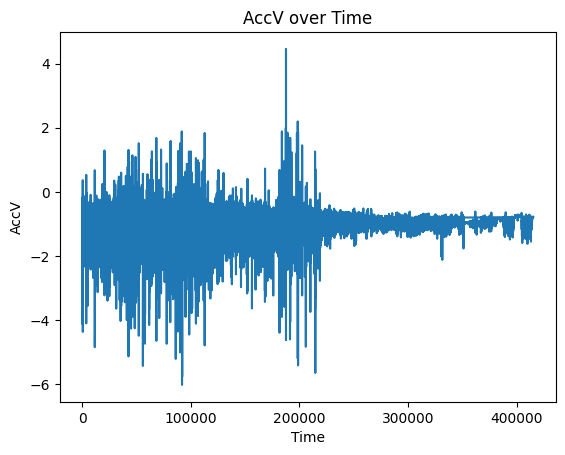

In [10]:
plt.plot(df_defog['Time'], df_defog['AccV'])
plt.title("AccV over Time")
plt.xlabel("Time")
plt.ylabel("AccV")

Text(0, 0.5, 'AccV')

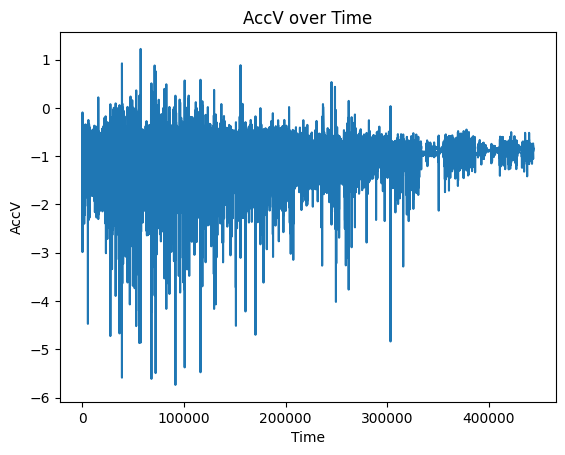

In [11]:
plt.plot(df_notype['Time'], df_notype['AccV'])
plt.title("AccV over Time")
plt.xlabel("Time")
plt.ylabel("AccV")

Text(0, 0.5, 'AccV')

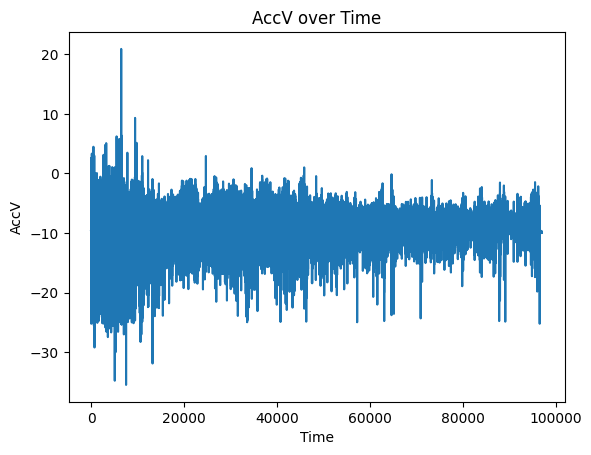

In [12]:
plt.plot(df_tdcsfog['Time'], df_tdcsfog['AccV'])
plt.title("AccV over Time")
plt.xlabel("Time")
plt.ylabel("AccV")

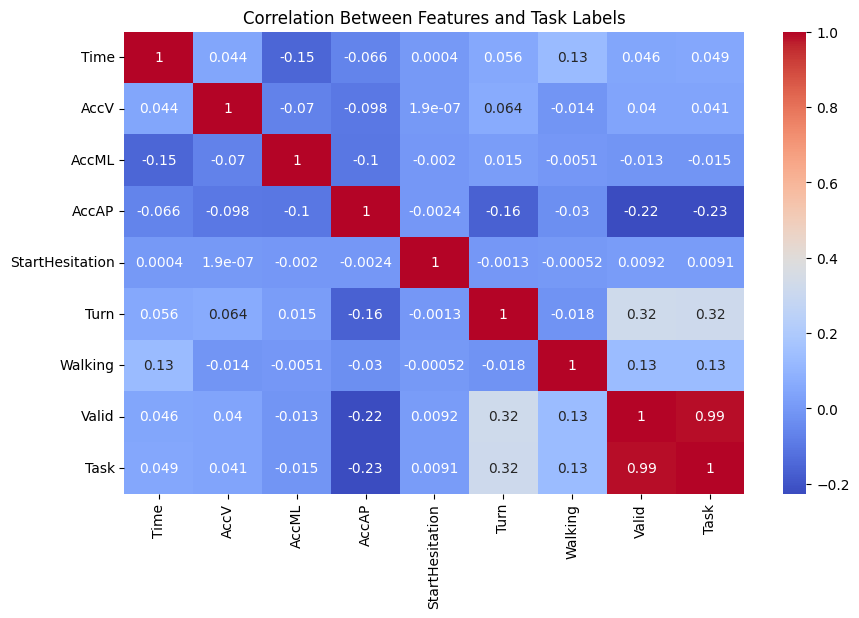

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_defog.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Features and Task Labels')
plt.show()

# Data Cleaning

Handle Missing Values
* Check missingness
* decide: drop columns or rows of too many missing values or impute (forward fill, backward fill, or interpolate)

Detect and correct erroneous values
* Spikes or dropouts in sensor readings
* Duplicated timestamps
* Values outside physical limits (e.g., g-force beyond ±16g if using IMUs)

Check for:
* Outliers: Z-score, IQR method
* Signal gaps
* Negative time values or duplicates

Normalize or standardize data using StandardScaler or MinMaxScaler

In [14]:
num_duplicates = df_defog['Time'].duplicated().sum()
print(f"Number of duplicate timestamps: {num_duplicates}")
df_unique_defog = df_defog.drop_duplicates(subset='Time', keep='first')

Number of duplicate timestamps: 13110314


In [15]:
df_unique_defog

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-1.002697,0.022371,0.068304,0,0,0,False,False
1,1,-1.002641,0.019173,0.066162,0,0,0,False,False
2,2,-0.999820,0.019142,0.067536,0,0,0,False,False
3,3,-0.998023,0.018378,0.068409,0,0,0,False,False
4,4,-0.998359,0.016726,0.066448,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...
415383,415383,-0.784720,-0.112226,0.622567,0,0,0,False,False
415384,415384,-0.784473,-0.111342,0.622026,0,0,0,False,False
415385,415385,-0.785686,-0.113234,0.623058,0,0,0,False,False
415386,415386,-0.787062,-0.113145,0.623059,0,0,0,False,False


In [16]:
print(df_defog.isnull())
print(df_defog.isnull().sum())
missing_rows = df_defog[df_defog.isnull().any(axis=1)]
print(missing_rows)

         Time   AccV  AccML  AccAP  StartHesitation   Turn  Walking  Valid  \
0       False  False  False  False            False  False    False  False   
1       False  False  False  False            False  False    False  False   
2       False  False  False  False            False  False    False  False   
3       False  False  False  False            False  False    False  False   
4       False  False  False  False            False  False    False  False   
...       ...    ...    ...    ...              ...    ...      ...    ...   
109120  False  False  False  False            False  False    False  False   
109121  False  False  False  False            False  False    False  False   
109122  False  False  False  False            False  False    False  False   
109123  False  False  False  False            False  False    False  False   
109124  False  False  False  False            False  False    False  False   

         Task  
0       False  
1       False  
2       False  